In [1]:
import shap
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

import xgboost as xgb
import os
import zipfile
import urllib.request

import shutil
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

#Question 1

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')


  0%|          | 0/100 [00:00<?, ?it/s]

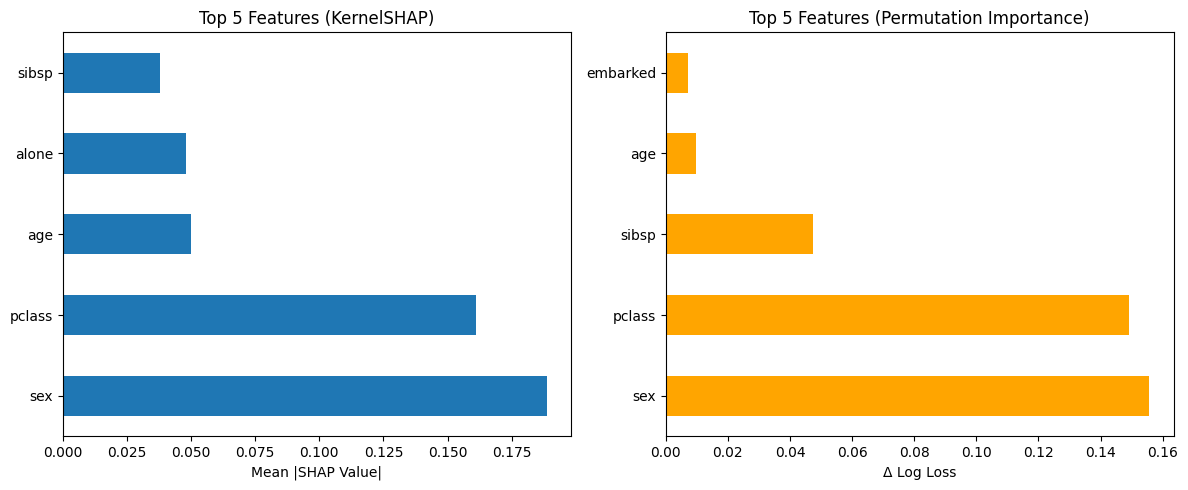


Top 5 Feature Comparison:

KernelSHAP Rank Permutation Rank
            sex              sex
         pclass           pclass
            age            sibsp
          alone              age
          sibsp         embarked


In [2]:
df = sns.load_dataset("titanic")
print(df.columns)
df = df[["pclass", "sex", "sibsp", "parch", "age", "fare", "alone", "embarked", "survived"]].dropna()

le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"])
df["embarked"] = le.fit_transform(df["embarked"])

X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test_sample = X_test.sample(n=100, random_state=1)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

background = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(lambda x: model.predict_proba(pd.DataFrame(x, columns=X.columns))[:, 1], background)

shap_values = explainer.shap_values(X_test_sample, nsamples=100)

shap_importance = np.abs(shap_values).mean(axis=0)
shap_ranking = pd.Series(shap_importance, index=X.columns).sort_values(ascending=False)

def permutation_importance(model, X, y, metric=log_loss):
    baseline_probs = model.predict_proba(X)
    baseline_score = metric(y, baseline_probs)
    importances = {}
    for col in X.columns:
        X_permuted = X.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col])
        permuted_probs = model.predict_proba(X_permuted)
        permuted_score = metric(y, permuted_probs)
        importances[col] = permuted_score - baseline_score
    return pd.Series(importances).sort_values(ascending=False)

perm_importance = permutation_importance(model, X_test_sample, y_test.loc[X_test_sample.index])

top5_shap = shap_ranking.head(5)
top5_perm = perm_importance.head(5)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
top5_shap.plot(kind='barh')
plt.title("Top 5 Features (KernelSHAP)")
plt.xlabel("Mean |SHAP Value|")

plt.subplot(1, 2, 2)
top5_perm.plot(kind='barh', color='orange')
plt.title("Top 5 Features (Permutation Importance)")
plt.xlabel("Δ Log Loss")

plt.tight_layout()
plt.show()

comparison = pd.DataFrame({
    'KernelSHAP Rank': top5_shap.index.tolist(),
    'Permutation Rank': top5_perm.index.tolist()
})
print("\nTop 5 Feature Comparison:\n")
print(comparison.to_string(index=False))


#Question 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

TreeSHAP Avg Non-zero Features per Instance: 8.00
KernelSHAP Avg Non-zero Features per Instance: 2.00


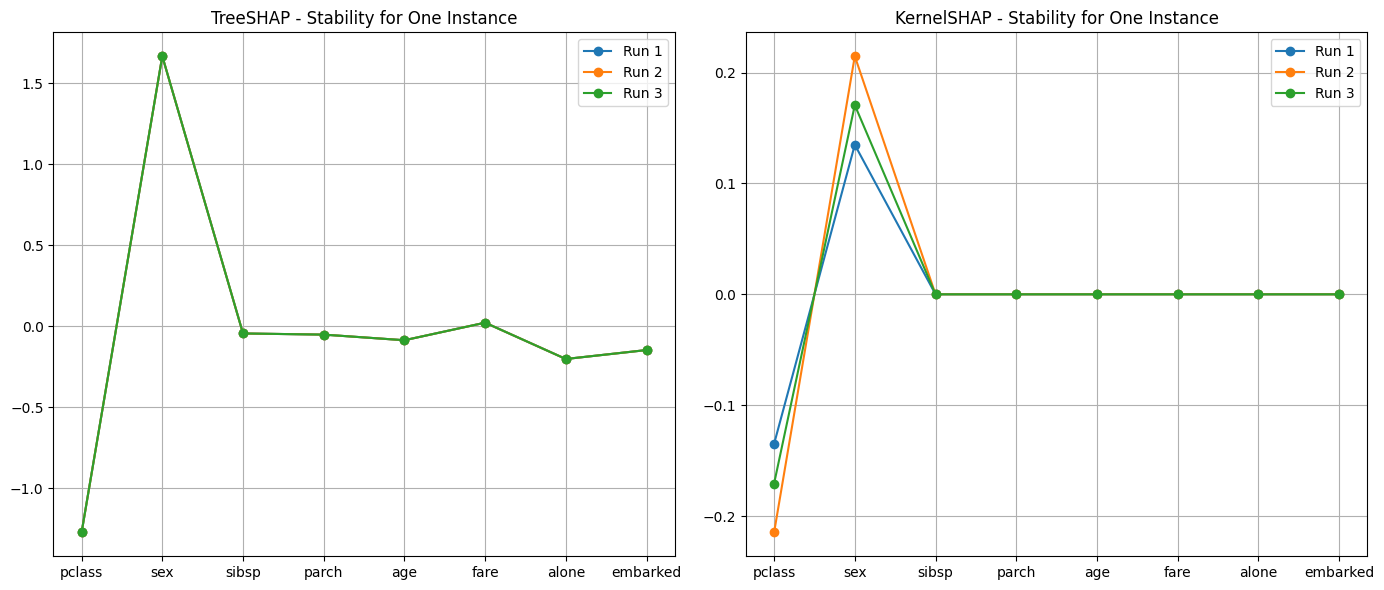

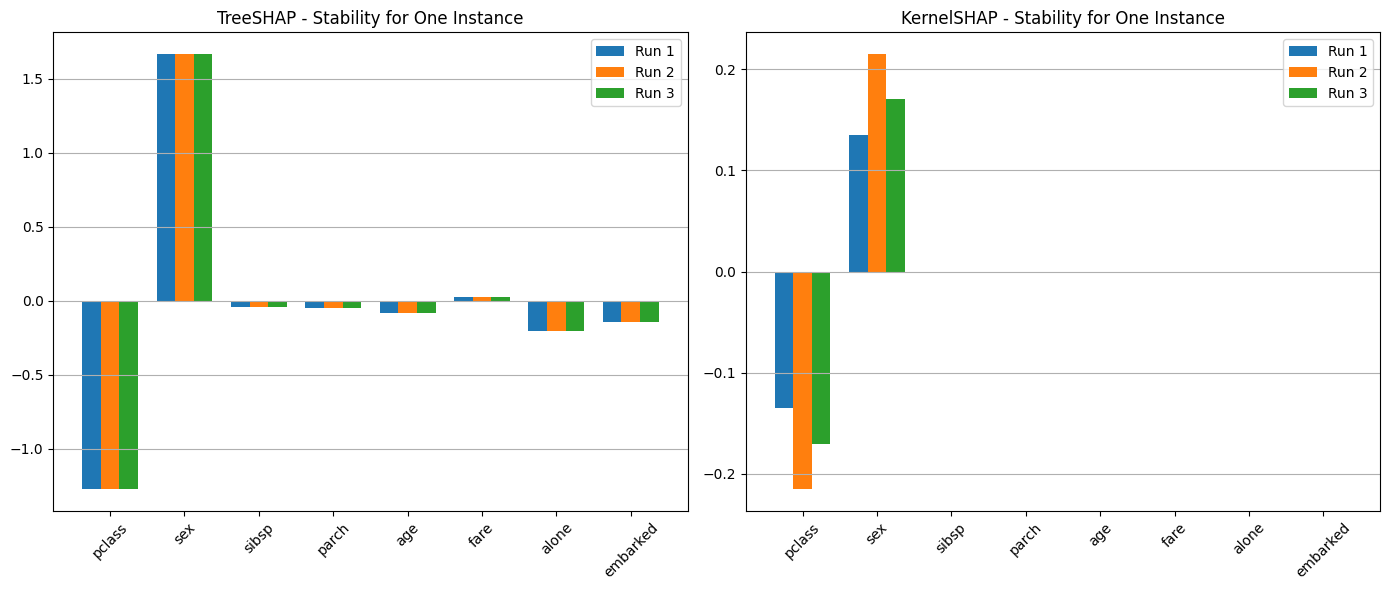

In [2]:
df = sns.load_dataset("titanic")
df = df[["pclass", "sex", "sibsp", "parch", "age", "fare", "alone", "embarked", "survived"]].dropna()

le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"])
df["embarked"] = le.fit_transform(df["embarked"])

X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test_sample = X_test.sample(100, random_state=42)

model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train.values, y_train.values)

def predict_proba_np(X):
    return model.predict_proba(np.array(X))

tree_shap_runs = []
for _ in range(3):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_test_sample)
    tree_shap_runs.append(np.array(shap_vals))

kernel_shap_runs = []
for seed in [0, 1, 2]:
    background = shap.sample(X_train, 10, random_state=seed)
    explainer = shap.KernelExplainer(predict_proba_np, background)
    shap_vals = explainer.shap_values(X_test_sample, nsamples='auto')[1]
    kernel_shap_runs.append(np.array(shap_vals))

def avg_non_zero(shap_values):
    return np.mean([np.count_nonzero(instance) for instance in shap_values])

tree_sparsity = np.mean([avg_non_zero(run) for run in tree_shap_runs])
kernel_sparsity = np.mean([avg_non_zero(run) for run in kernel_shap_runs])

print(f"TreeSHAP Avg Non-zero Features per Instance: {tree_sparsity:.2f}")
print(f"KernelSHAP Avg Non-zero Features per Instance: {kernel_sparsity:.2f}")


instance_idx = 0
features = X_test_sample.columns.tolist()
tree_vals = np.array([run[instance_idx] for run in tree_shap_runs])

def to_full_shap_vector(shap_array, expected_len):
    if len(shap_array) == expected_len:
        return shap_array
    out = np.zeros(expected_len)
    out[:len(shap_array)] = shap_array
    return out

kernel_vals = np.array([to_full_shap_vector(run[instance_idx], len(features)) for run in kernel_shap_runs])


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for i in range(3):
    axs[0].plot(features, tree_vals[i], marker='o', label=f'Run {i+1}')
axs[0].set_title("TreeSHAP - Stability for One Instance")
axs[0].legend()
axs[0].grid()

for i in range(3):
    axs[1].plot(features, kernel_vals[i], marker='o', label=f'Run {i+1}')
axs[1].set_title("KernelSHAP - Stability for One Instance")
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()


x = np.arange(len(features))
width = 0.25

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].bar(x - width, tree_vals[0], width, label='Run 1')
axs[0].bar(x, tree_vals[1], width, label='Run 2')
axs[0].bar(x + width, tree_vals[2], width, label='Run 3')
axs[0].set_title("TreeSHAP - Stability for One Instance")
axs[0].set_xticks(x)
axs[0].set_xticklabels(features, rotation=45)
axs[0].legend()
axs[0].grid(axis='y')

axs[1].bar(x - width, kernel_vals[0], width, label='Run 1')
axs[1].bar(x, kernel_vals[1], width, label='Run 2')
axs[1].bar(x + width, kernel_vals[2], width, label='Run 3')
axs[1].set_title("KernelSHAP - Stability for One Instance")
axs[1].set_xticks(x)
axs[1].set_xticklabels(features, rotation=45)
axs[1].legend()
axs[1].grid(axis='y')
plt.tight_layout()
plt.show()
